In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import Choropleth
from folium.plugins import HeatMap
import datetime
import warnings

warnings.simplefilter("ignore")
np.random.seed(0)

**GeoPandas** is an open-source Python library that extends the popular data manipulation library, Pandas, to add support for **geographic data**. It provides convenient data structures and functions for working with geospatial data, such as points, lines, polygons, and multi-geometry collections.

In [2]:
data = pd.read_csv("database.csv")
#dropping columns with missing values
missing_values_columns = [col for col in data.columns if data[col].isnull().any()]
data = data.drop(missing_values_columns, axis=1)
data.head(3)

,Date,Time,Latitude,Longitude,Type,Depth,Magnitude,ID,Source,Location Source,Magnitude Source,Status
0,01/02/1965,13:44:18,19.246,145.616,Earthquake,131.6,6.0,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,80.0,5.8,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,20.0,6.2,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic


In [4]:
tectonic_plates = pd.read_csv("all.csv" )
tectonic_plates.head()

,plate,lat,lon
0,am,30.754,132.824
1,am,30.970,132.965
2,am,31.216,133.197
3,am,31.515,133.500
4,am,31.882,134.042


This data on earthquakes start in 1965. The geologists concluded that the **seismic events** show a strong linkage to the landscape of **Plate Tectonics**. So our second dataset is that of the geospatial locations of Tectonic Plate Boundaries.<br>
**Earthquake Data :-** This includes a record of the date, time, location, depth, magnitude, and source of every earthquake with a reported magnitude of 5.5 or higher since 1965 up to 2016.<br>
**Plate Tectonic Data :-** This contains latitude and longtitude data that completely encloses 56 tectonic plates. 

## Data Preprocessing
* **Parsing Date :-** Parsed date to dtype datetime64(ns)
* **Parsing Time :-** Parsed time to dtype timedelta64
* Adding attributes **"Date_Time"** which contains parsed values of datetime combined and **"Days"** which contains parsed days of week. 

In [5]:
lengths = data["Date"].str.len()
lengths.value_counts()

Date
10    23409
24        3
Name: count, dtype: int64

In [6]:
wrongdates = np.where([lengths == 24])[1]
print("Fishy dates:", wrongdates)
data.loc[wrongdates]

Fishy dates: [ 3378  7512 20650]


,Date,Time,Latitude,Longitude,Type,Depth,Magnitude,ID,Source,Location Source,Magnitude Source,Status
3378,1975-02-23T02:58:41.000Z,1975-02-23T02:58:41.000Z,8.017,124.075,Earthquake,623.0,5.6,USP0000A09,US,US,US,Reviewed
7512,1985-04-28T02:53:41.530Z,1985-04-28T02:53:41.530Z,-32.998,-71.766,Earthquake,33.0,5.6,USP0002E81,US,US,HRV,Reviewed
20650,2011-03-13T02:23:34.520Z,2011-03-13T02:23:34.520Z,36.344,142.344,Earthquake,10.1,5.8,USP000HWQP,US,US,GCMT,Reviewed


Fixing wrong dates and changing the datatype from numpy object to datetime64(ns) as we can see above the dates are not mentioned in the correct way as the rest of the rows.

In [7]:
data.loc[3378, "Date"] = "02/23/1975"  
data.loc[7512, "Date"] = "04/28/1985"
data.loc[20650, "Date"] = "03/13/2011"
data['Date']= pd.to_datetime(data["Date"])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23412 entries, 0 to 23411
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              23412 non-null  datetime64[ns]
 1   Time              23412 non-null  object        
 2   Latitude          23412 non-null  float64       
 3   Longitude         23412 non-null  float64       
 4   Type              23412 non-null  object        
 5   Depth             23412 non-null  float64       
 6   Magnitude         23412 non-null  float64       
 7   ID                23412 non-null  object        
 8   Source            23412 non-null  object        
 9   Location Source   23412 non-null  object        
 10  Magnitude Source  23412 non-null  object        
 11  Status            23412 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(7)
memory usage: 2.1+ MB


In [8]:
lengths = data["Time"].str.len()
lengths.value_counts()

Time
8     23409
24        3
Name: count, dtype: int64

In [9]:
wrongtime = np.where([lengths == 24])[1]
print("Fishy time:", wrongtime)
data.loc[wrongtime]

Fishy time: [ 3378  7512 20650]


,Date,Time,Latitude,Longitude,Type,Depth,Magnitude,ID,Source,Location Source,Magnitude Source,Status
3378,1975-02-23,1975-02-23T02:58:41.000Z,8.017,124.075,Earthquake,623.0,5.6,USP0000A09,US,US,US,Reviewed
7512,1985-04-28,1985-04-28T02:53:41.530Z,-32.998,-71.766,Earthquake,33.0,5.6,USP0002E81,US,US,HRV,Reviewed
20650,2011-03-13,2011-03-13T02:23:34.520Z,36.344,142.344,Earthquake,10.1,5.8,USP000HWQP,US,US,GCMT,Reviewed


Similarly time of these 3 rows are also not mentioned in the proper way as the rest of the rows so we will fix the time also.

In [10]:
data.loc[3378, "Time"] = "02:58:41"
data.loc[7512, "Time"] = "02:53:41"
data.loc[20650, "Time"] = "02:23:34"
data['Time']= pd.to_timedelta(data['Time'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23412 entries, 0 to 23411
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   Date              23412 non-null  datetime64[ns] 
 1   Time              23412 non-null  timedelta64[ns]
 2   Latitude          23412 non-null  float64        
 3   Longitude         23412 non-null  float64        
 4   Type              23412 non-null  object         
 5   Depth             23412 non-null  float64        
 6   Magnitude         23412 non-null  float64        
 7   ID                23412 non-null  object         
 8   Source            23412 non-null  object         
 9   Location Source   23412 non-null  object         
 10  Magnitude Source  23412 non-null  object         
 11  Status            23412 non-null  object         
dtypes: datetime64[ns](1), float64(4), object(6), timedelta64[ns](1)
memory usage: 2.1+ MB


Adding a new column which is combination of data and time.

In [13]:
data["Date_Time"]=data["Date"] + data["Time"]
data["Days"] = data.Date.dt.strftime("%A")

In [14]:
data.head(1)

,Date,Time,Latitude,Longitude,Type,Depth,Magnitude,ID,Source,Location Source,Magnitude Source,Status,Date_Time,Days
0,1965-01-02,0 days 13:44:18,19.246,145.616,Earthquake,131.6,6.0,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic,1965-01-02 13:44:18,Saturday


Here we have apply **.dt** method of pandas library allows us to apply datetime-related methods to the "Date" column. **.strftime("%A")** method converts datetime objects into formatted strings. The argument **"%A"** specifies the format of the output string, which represents the full name of the day of the week (e.g., "Monday", "Tuesday", etc.).<br>
This line of code will create a column "Days" in which the day on which the earthquake occured will be mentioned.

## Data Analysis
We begin our analysis by plotting a **line plot** of magnitudes with dates. This showed a time series of various earthquakes on the planet from 1965 to 2016. Taking the first look at the plot we may conclude that there was a relatively **high seismic activity** from 1965 to early 1970s.<br>
### Plotting lineplot with Magnitudes w.r.t Dates

Text(0.5, 0, 'Date')

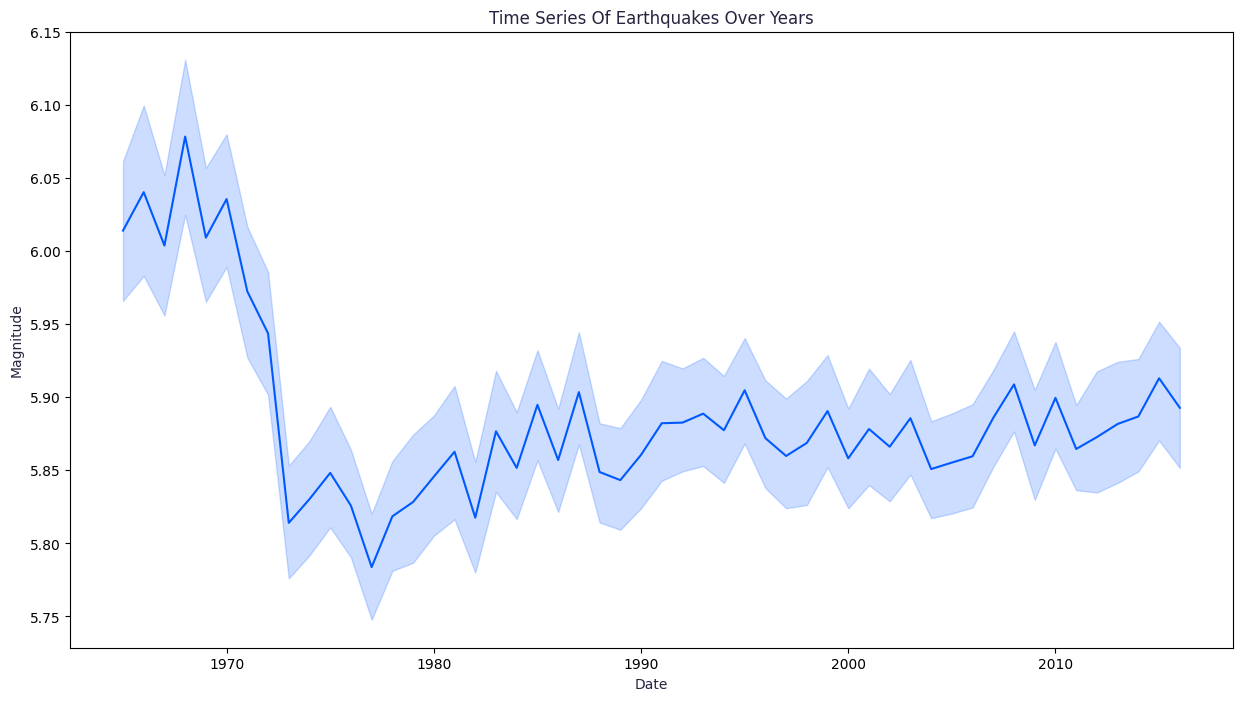

In [15]:
plt.figure(figsize=(15,8))
Time_series=sns.lineplot(x=data['Date'].dt.year, y="Magnitude", data=data, color="#0059ff")
Time_series.set_title("Time Series Of Earthquakes Over Years", color="#282440")
Time_series.set_ylabel("Magnitude", color="#282440")
Time_series.set_xlabel("Date", color="#282440")

This data also includes earthquake caused by **nuclear explosions, explosions** and **rockburst**. In order to have a clear distinction about the seismic activities, we must rule out if this high magnitude events were due to other man-made causes.<br>
### Plotting Timeseries w.r.t Type


Text(0.5, 0, 'Date')

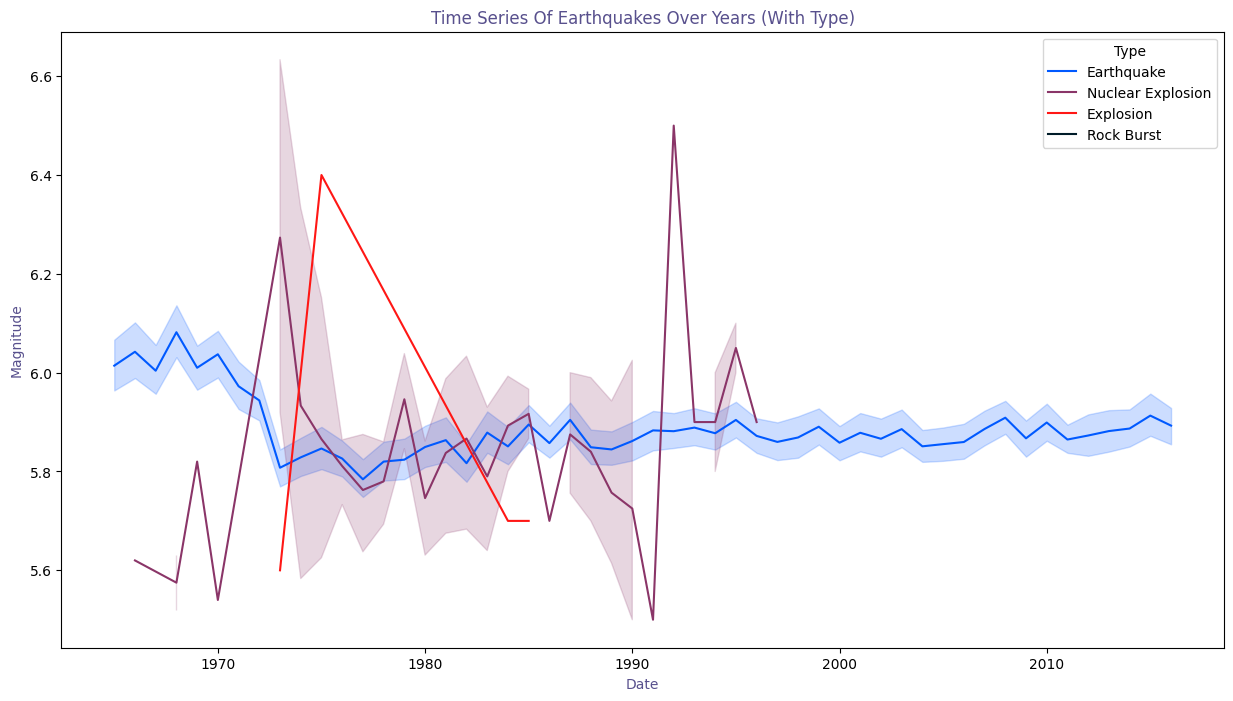

In [16]:
plt.figure(figsize=(15,8))
colours = ["#0059ff","#8a3568","#ff1715","#001c29"]
Time_series_Type=sns.lineplot(x=data['Date'].dt.year, y="Magnitude", data=data, hue="Type", palette=colours)
Time_series_Type.set_title("Time Series Of Earthquakes Over Years (With Type)", color="#58508d")
Time_series_Type.set_ylabel("Magnitude", color="#58508d")
Time_series_Type.set_xlabel("Date", color="#58508d")

From the above plot, we may conclude that there were, indeed, relatively high magnitude events in the late 60s and early 70s. However, not all of those were due to seismic causes.Much of it was associate with other causes. The plot shows a peek in nuclear explosions and explosions in the 1970s. <br> 
### Plotting Earthquake in terms of Days of Week

Text(0.5, 0, 'Days Of Week')

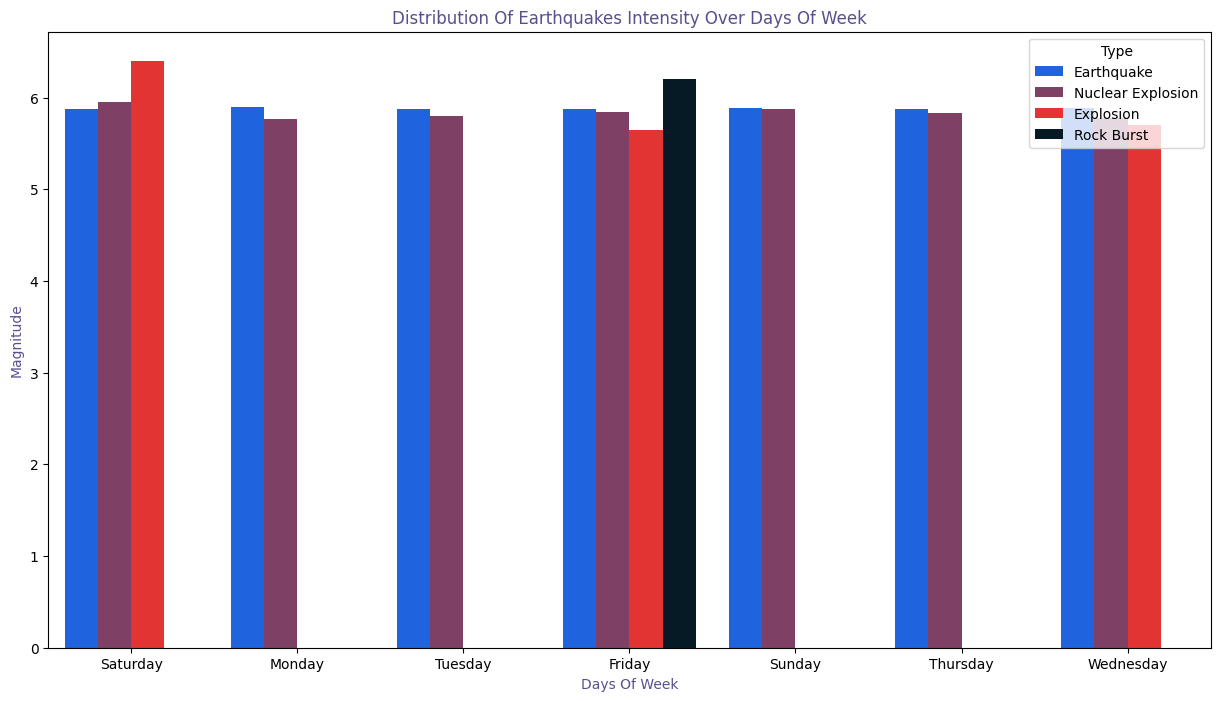

In [18]:
plt.figure(figsize=(15,8))
Days_of_week=sns.barplot(x=data['Days'], y="Magnitude", data=data, ci=None, hue="Type", palette=colours)
Days_of_week.set_title("Distribution Of Earthquakes Intensity Over Days Of Week", color="#58508d")
Days_of_week.set_ylabel("Magnitude", color="#58508d")
Days_of_week.set_xlabel("Days Of Week", color="#58508d")

### Plotting the Depth of Earthquake and Mean Depth

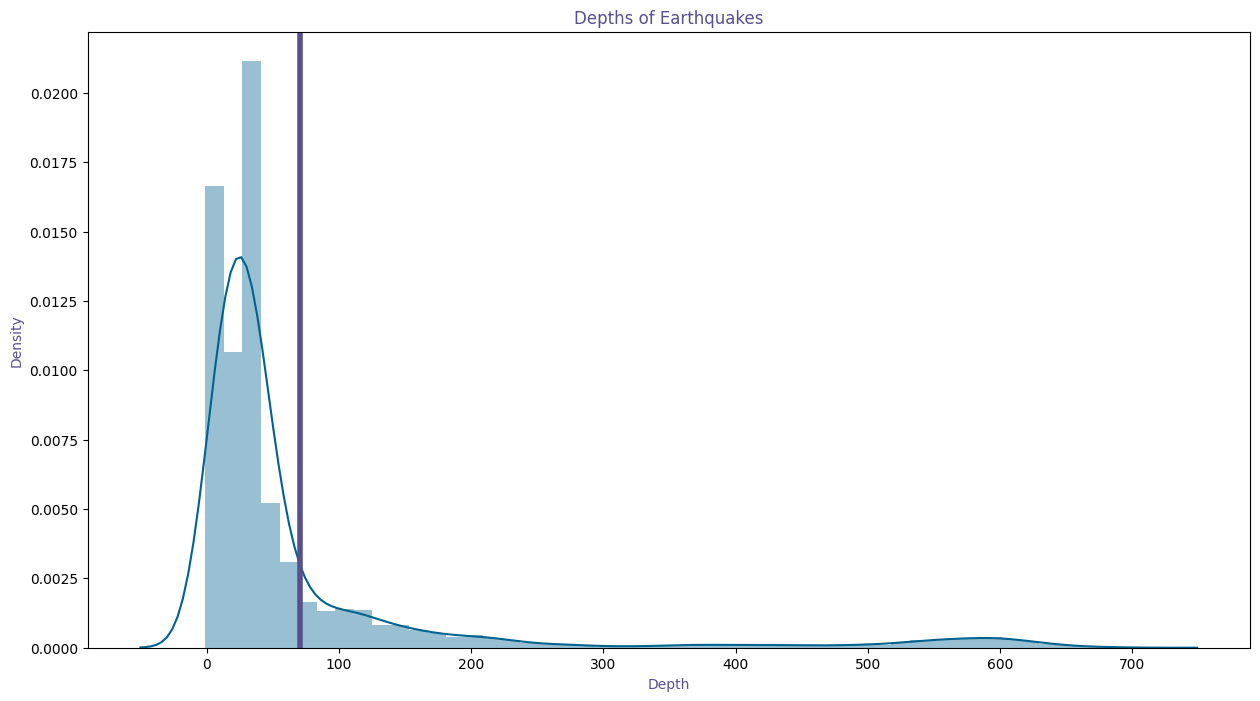

In [19]:
plt.figure(figsize=(15,8))
depth = data["Depth"].values
mean_D = data["Depth"].mean()
Depth_plot = sns.distplot(depth, color="#00628f")
Depth_plot.set_title("Depths of Earthquakes", color="#58508d")
Depth_plot.set_ylabel("Density", color="#58508d")
Depth_plot.set_xlabel("Depth", color="#58508d")

plt.axvline(mean_D, 0,1, color="#58508d", linewidth=4, label="Mean")

### Plotting the Magnitude of Earthquake and Mean Magnitute

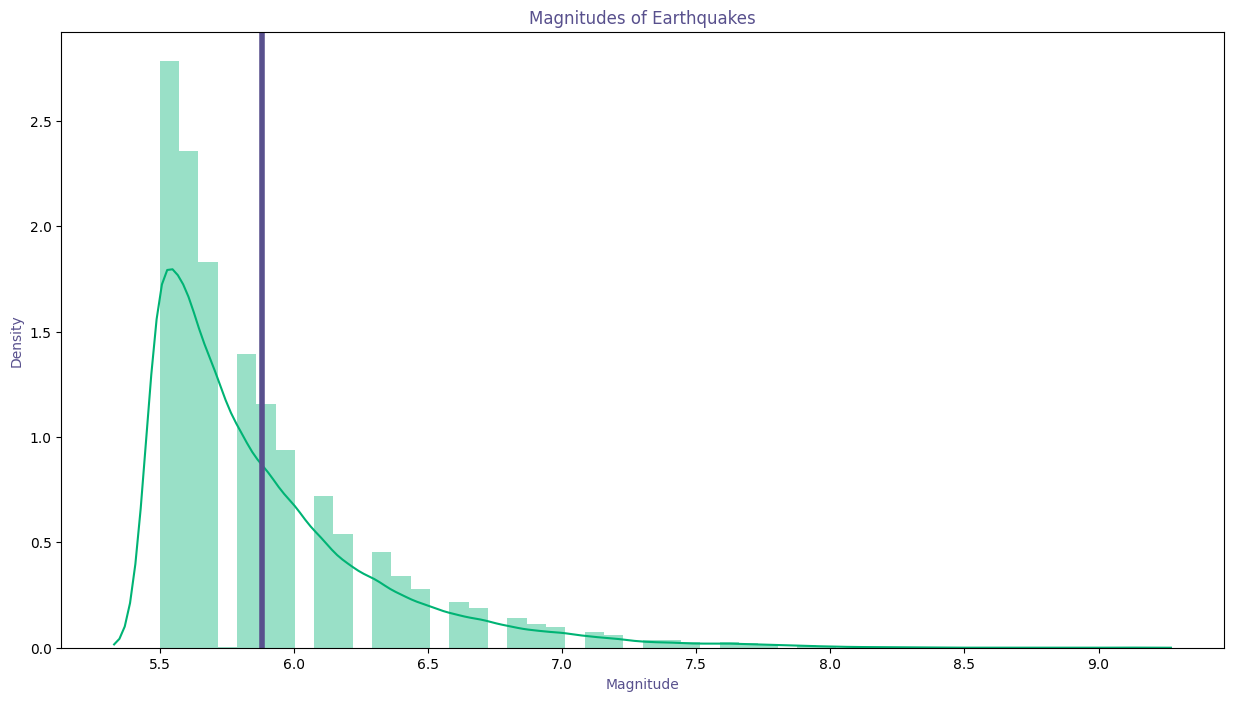

In [20]:
plt.figure(figsize=(15,8))
strength = data["Magnitude"].values
mean_M= data["Magnitude"].mean()
Magnitude_plot = sns.distplot(strength, color ="#00b374")
Magnitude_plot.set_title("Magnitudes of Earthquakes", color="#58508d")
Magnitude_plot.set_ylabel("Density", color="#58508d")
Magnitude_plot.set_xlabel("Magnitude", color="#58508d")

plt.axvline(mean_M,0,1, color="#58508d",linewidth=4,label="Mean")

## Geospatial Analysis and Visualization
Earth’s crust, the uppermost layer of earth, is extremely thin in comparison to the volume of the Earth compared to what lies below it. It has an uneven thickness of as little as 5 km (at Hawaii) to as thick as 70 km. `The crust is broken into large pieces called tectonic plates`. It is speculated that the heat-driven **convection currents** of magma in the mantle of the earth makes these plates move **1.2 to 2 inches each year**. This movement of plated explains many geological phenomena. It is believed to cause most earthquakes and volcanoes on earth.ata.

### Ploting the Tectonic Plate's Boundaries

In [22]:
# tectonic = folium.Map(tiles="cartodbpositron", zoom_start=5)

# plates = list(tectonic_plates["plate"].unique())
# for plate in plates:
#     plate_vals = tectonic_plates[tectonic_plates["plate"] == plate]
#     lats = plate_vals["lat"].values
#     lons = plate_vals["lon"].values
#     points = list(zip(lats, lons))
#     indexes = [None] + [i + 1 for i, x in enumerate(points) if i < len(points) - 1 and abs(x[1] - points[i + 1][1]) > 300] + [None]
#     for i in range(len(indexes) - 1):
#         folium.vector_layers.PolyLine(points[indexes[i]:indexes[i+1]], popup=plate, color="#8d5850", fill=False, ).add_to(tectonic)
# tectonic

![SS1](SS1.png)

### Plotting the Plates along with the Earthquake

In [24]:
# tectonic_quake = folium.Map(tiles="cartodbpositron", zoom_start=5)
# gradient = {.33: "#e60051", .66: "#b3003f", 1: "#670024"} 
# plates = list(tectonic_plates["plate"].unique())
# for plate in plates:
#     plate_vals = tectonic_plates[tectonic_plates["plate"] == plate]
#     lats = plate_vals["lat"].values
#     lons = plate_vals["lon"].values
#     points = list(zip(lats, lons))
#     indexes = [None] + [i + 1 for i, x in enumerate(points) if i < len(points) - 1 and abs(x[1] - points[i + 1][1]) > 300] + [None]
#     for i in range(len(indexes) - 1):
#         folium.vector_layers.PolyLine(points[indexes[i]:indexes[i+1]], popup=plate, fill=False,  color="#58508d").add_to(tectonic_quake)
#         HeatMap(data=data[["Latitude", "Longitude"]],hue="Magnitude",min_opacity=0.5,radius=1,gradient=gradient).add_to(tectonic_quake)
# tectonic_quake

![SS2](SS2.png)

The plate boundaries do coincide with the earthquakes in this data. However, some of the data points are of the earthquakes are caused by other events (In column "Types"; namely, "NuclearExplosion", "Explosion"&"Rock Burst"). Let's plot only the **Type-Earthquakes** to see the difference.<br>
### Plotting Plate Boundaries along with Earthquakes of "Type: Earthquake"

In [25]:
data_onlyquakes= data.set_index("Type") 
data_onlyquakes=data_onlyquakes.drop(["Nuclear Explosion","Explosion","Rock Burst"],axis=0)

In [26]:
# tectonic_quake = folium.Map(tiles="cartodbpositron", zoom_start=5)
# plates = list(tectonic_plates["plate"].unique())
# for plate in plates:
#     plate_vals = tectonic_plates[tectonic_plates["plate"] == plate]
#     lats = plate_vals["lat"].values
#     lons = plate_vals["lon"].values
#     points = list(zip(lats, lons))
#     indexes = [None] + [i + 1 for i, x in enumerate(points) if i < len(points) - 1 and abs(x[1] - points[i + 1][1]) > 300] + [None]
#     for i in range(len(indexes) - 1):
#         folium.vector_layers.PolyLine(points[indexes[i]:indexes[i+1]], popup=plate, fill=False,  color="#58508d").add_to(tectonic_quake)
#         HeatMap(data=data_onlyquakes[["Latitude", "Longitude"]], min_opacity=0.5,max_zoom=40,max_val=0.5,radius=1,gradient=gradient).add_to(tectonic_quake)

# tectonic_quake

![SS2](SS2.png)

This shows that some of the earthquakes that lie away from the boundaries of the tectonic plates were, in fact, caused by events as; Nuclear, Explosion or Rock Burst. Majority of earthquakes are around the edge of the tectonic plates. This shows a clear visualisation of the relation between earthquakes and tectonic plates.<br>
After establishing the relation of earthquakes with the plates, now we are going to examine if there is any association of tectonic plates and the magnitude or depth of earthquakes.<br>
For the Magnitude, we plot magnitudes in three ranges<br>

 1)Magnitude with values less than 5. 
 
2)Magnitude with values less than6.5 

3)Magnitude with values more than 6.5

### Create a base map with Plate Boundaries and Deapth

In [27]:
# Mag_tectonics  = folium.Map(tiles="cartodbpositron", zoom_start=5)
# gradient = {.33: "#628d82", .66: "#a3c5bf", 1: "#eafffd"} 
# plates = list(tectonic_plates["plate"].unique())
# for plate in plates:
#     plate_vals = tectonic_plates[tectonic_plates["plate"] == plate]
#     lats = plate_vals["lat"].values
#     lons = plate_vals["lon"].values
#     points = list(zip(lats, lons))
#     indexes = [None] + [i + 1 for i, x in enumerate(points) if i < len(points) - 1 and abs(x[1] - points[i + 1][1]) > 300] + [None]
#     for i in range(len(indexes) - 1):
#         folium.vector_layers.PolyLine(points[indexes[i]:indexes[i+1]], fill=False,  color="#58508d").add_to(Mag_tectonics)
        
# def colormag(val):
#             if val < 5.9:
#                 return "#ffcf6a"
#             elif val < 6.5:
#                 return "#fb8270"
#             else:
#                 return "#bc5090"
            
# for i in range(0,len(data)):
#     folium.Circle(location=[data.iloc[i]["Latitude"], data.iloc[i]["Longitude"]],radius=2000, color=colormag(data.iloc[i]["Magnitude"])).add_to(Mag_tectonics)

# #A bit of extra code to get legent 
# from branca.element import Template, MacroElement

# template = """
# {% macro html(this, kwargs) %}

# <!doctype html>
# <html lang="en">
# <head>
#   <meta charset="utf-8">
#   <meta name="viewport" content="width=device-width, initial-scale=1">
#   <title>jQuery UI Draggable - Default functionality</title>
#   <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

#   <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
#   <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>

# </head>
# <body>

 
# <div id='maplegend' class='maplegend' 
#     style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
#      border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
# <div class='legend-title'>Magnitude Scale </div>
# <div class='legend-scale'>
#   <ul class='legend-labels'>
#     <li><span style='background:#ffcf6a;opacity:1;'></span>values less than 5.9</li>
#     <li><span style='background:#fb8270;opacity:1;'></span>values less than 6.5</li>
#     <li><span style='background:#bc5090;opacity:1;'></span>values less than 6.5</li>

#   </ul>
# </div>
# </div>
 
# </body>
# </html>

# <style type='text/css'>
#   .maplegend .legend-title {
#     text-align: left;
#     margin-bottom: 5px;
#     font-weight: bold;
#     font-size: 90%;
#     }
#   .maplegend .legend-scale ul {
#     margin: 0;
#     margin-bottom: 5px;
#     padding: 0;
#     float: left;
#     list-style: none;
#     }
#   .maplegend .legend-scale ul li {
#     font-size: 80%;
#     list-style: none;
#     margin-left: 0;
#     line-height: 18px;
#     margin-bottom: 2px;
#     }
#   .maplegend ul.legend-labels li span {
#     display: block;
#     float: left;
#     height: 16px;
#     width: 30px;
#     margin-right: 5px;
#     margin-left: 0;
#     border: 1px solid #999;
#     }
#   .maplegend .legend-source {
#     font-size: 80%;
#     color: #777;
#     clear: both;
#     }
#   .maplegend a {
#     color: #777;
#     }
# </style>
# {% endmacro %}"""

# macro = MacroElement()
# macro._template = Template(template)

# Mag_tectonics.get_root().add_child(macro)

# Mag_tectonics

![SS4](SS4.png)

We can see that the magnitude distribution of earthquakes does not hold any association with plate boundaries. There does not appear to be any pattern and the magnitude is randomly distributed. We may discard any relation of the magnitude of earthquakes with plate location. 
<br>
For the Depth, we plot depth in three ranges
1) The Depth values less than 50 KM 
2) The Depth values less than 100 KM
3) The Depth values more than 100 km

In [28]:
# Depth_tectonics  = folium.Map(tiles="cartodbpositron", zoom_start=5)
# gradient = {.33: "#628d82", .66: "#a3c5bf", 1: "#eafffd"} 
# plates = list(tectonic_plates["plate"].unique())
# for plate in plates:
#     plate_vals = tectonic_plates[tectonic_plates["plate"] == plate]
#     lats = plate_vals["lat"].values
#     lons = plate_vals["lon"].values
#     points = list(zip(lats, lons))
#     indexes = [None] + [i + 1 for i, x in enumerate(points) if i < len(points) - 1 and abs(x[1] - points[i + 1][1]) > 300] + [None]
#     for i in range(len(indexes) - 1):
#         folium.vector_layers.PolyLine(points[indexes[i]:indexes[i+1]],fill=False,  color="#58508d").add_to(Depth_tectonics)
        
# def colordepth(val):
#             if val < 50:
#                 return "#ffcf6a"
#             elif val < 100:
#                 return "#fb8270"
#             else:
#                 return "#bc5090"
            
# for i in range(0,len(data)):
#     folium.Circle(location=[data.iloc[i]["Latitude"], data.iloc[i]["Longitude"]],radius=2000, color=colordepth(data.iloc[i]["Depth"])).add_to(Depth_tectonics)

# #A bit of extra code to get legent 
# from branca.element import Template, MacroElement

# template = """
# {% macro html(this, kwargs) %}

# <!doctype html>
# <html lang="en">
# <head>
#   <meta charset="utf-8">
#   <meta name="viewport" content="width=device-width, initial-scale=1">
#   <title>jQuery UI Draggable - Default functionality</title>
#   <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

#   <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
#   <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>

# </head>
# <body>

 
# <div id='maplegend' class='maplegend' 
#     style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
#      border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
# <div class='legend-title'>Depth Scale </div>
# <div class='legend-scale'>
#   <ul class='legend-labels'>
#     <li><span style='background:#ffcf6a;opacity:1;'></span>Depth less than 50</li>
#     <li><span style='background:#fb8270;opacity:1;'></span>Depth less than 100</li>
#     <li><span style='background:#bc5090;opacity:1;'></span>Depth more than 100</li>

#   </ul>
# </div>
# </div>
 
# </body>
# </html>

# <style type='text/css'>
#   .maplegend .legend-title {
#     text-align: left;
#     margin-bottom: 5px;
#     font-weight: bold;
#     font-size: 90%;
#     }
#   .maplegend .legend-scale ul {
#     margin: 0;
#     margin-bottom: 5px;
#     padding: 0;
#     float: left;
#     list-style: none;
#     }
#   .maplegend .legend-scale ul li {
#     font-size: 80%;
#     list-style: none;
#     margin-left: 0;
#     line-height: 18px;
#     margin-bottom: 2px;
#     }
#   .maplegend ul.legend-labels li span {
#     display: block;
#     float: left;
#     height: 16px;
#     width: 30px;
#     margin-right: 5px;
#     margin-left: 0;
#     border: 1px solid #999;
#     }
#   .maplegend .legend-source {
#     font-size: 80%;
#     color: #777;
#     clear: both;
#     }
#   .maplegend a {
#     color: #777;
#     }
# </style>
# {% endmacro %}"""

# macro = MacroElement()
# macro._template = Template(template)

# Depth_tectonics.get_root().add_child(macro)

# Depth_tectonics

![SS5](SS5.png)

There appears to be a correlation between the depth of an earthquake and its distance from plate boundaries. When we look closely, we may see a pattern. Earthquakes closer to plate borders tend to be **shallower**, whereas earthquakes further away appear to be **deeper**. 

## Conclusion
**Tectonic Plate Boundaries are more prone to Earthquakes**, there was strong evidence in the geospatial analysis.<br>
**The Depth of Earthquake near the Plate Boundaries are Shallow**, as the distance increases from plate boundaries the earthquakes becomes **deeper in origin**. Our analysis also discards any relation of magnitude of the earthquakes with teh distance from the plate boundaries. 

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Provided data
data = {
    'Latitude': [19.246, 1.863, -20.579, -59.076, 11.938],
    'Longitude': [145.616, 127.352, -173.972, -23.557, 126.427],
    'Depth': [131.6, 80.0, 20.0, 15.0, 15.0],
    'Magnitude': [6.0, 5.8, 6.2, 5.8, 5.8]
}

# Create DataFrame
df = pd.DataFrame(data)

# Split data into features (X) and target (y)
X = df[['Latitude', 'Longitude', 'Depth']]
y = df['Magnitude']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the testing data
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

# Example prediction
new_data = [[10.0, 100.0, 50.0]]  # Example latitude, longitude, depth
predicted_magnitude = model.predict(new_data)
print("Predicted Magnitude:", predicted_magnitude[0])

Mean Squared Error: 0.0201640000000001
Predicted Magnitude: 5.924000000000001
